In [161]:
# ### '''Installation'''
# !pip install qiskit[visualization]==1.1.0
# # Use the following if you are on MacOS/zsh
# #!pip install 'qiskit[visualization]'==1.1.0
# !pip install qiskit_aer
# !pip install qiskit_ibm_runtime
# !pip install matplotlib
# !pip install pylatexenc
# !pip install prototype-zne
# !pip install tqdm
# from IPython.display import clear_output
# clear_output()

In [162]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.visualization import *
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi
from tqdm.notebook import tqdm

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


# Tight-binding Model

<!-- <div>
<img src="attachment:tight-binding.png" width="400"/>
</div> -->
![tightbindingmodel](https://github.com/qiskit-community/ibm-quantum-spring-challenge-2022/blob/main/exercise1/resources/tight-binding.png?raw=true)

The tight-binding model is a quantum mechanical picture used to describe the conductance of electrons in solid-state materials. In this model, each atom is treated as a lattice site and the particle needs energy $\epsilon_i$ to occupy that site. The electron can tunnel from a site to its neighbors with an energy cost of $J$. The following Hamiltonian describes this model:

$$H_{\rm tb}/\hbar = \sum_i \epsilon_i Z_i + J \sum_{\langle i,j \rangle} (X_i X_j + Y_i Y_j)$$

The first term in the Hamiltonian describes the on-site energy of each site, and the second term describes the interaction energy between neighboring lattice sites.

The system Hamiltonian allows us to determine how the quantum state evolves with time. This time evolution is governed by the Schrodinger equation:

$$ i \hbar \frac{\partial}{\partial t}|\psi(t)\rangle = H |\psi(t)\rangle $$

In case of a time-independent Hamiltonian (a Hamiltonian that doesn't change with time), the solution to the Schrodinger equation will take the form below:

$$ |\psi(t)\rangle = e^{-i H t / \hbar} |\psi(0)\rangle $$

We study the time dynamics under the tight-binding Hamiltonian, and construct a Trotterized circuit for its time evolution.

## 1. Time evolution under the tight-binding Hamiltonian

First, let's consider time evolution under the tight-binding Hamiltonian with 3 sites. Here we'll set $J=1$, and $\epsilon_i=0$ for a uniform lattice.

In [163]:
# Import Pauli operators (I, X, Y, Z)
from qiskit.quantum_info import Pauli

J = 1
I=Pauli('I')
X=Pauli('X')
Y=Pauli('Y')
Z=Pauli('Z')

# tight-binding Hamiltonian
def H_tb():
    # Interactions (I is the identity matrix; X and Y are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X).to_matrix() + (X^X^I).to_matrix()
    YYs = (I^Y^Y).to_matrix() + (Y^Y^I).to_matrix()

    # Sum interactions
    H = J*(XXs + YYs)

    # Return Hamiltonian
    return H

In [165]:
# Unitary evolution under the tight-binding Hamiltonian
def U_tb(t):
    H =np.exp(-1j*H_tb()*t)
    Q, R = np.linalg.qr(H)

    # Normalize Q to ensure it is unitary
    Q = Q / np.linalg.norm(Q, axis=0)
    
    return UnitaryGate(Q)

We initialize the state of our system to $|100\rangle$, and track the probabilities of the states $|100\rangle, |010\rangle, |001\rangle$. These values correspond to the probability of finding the particle on each different site of our lattice.

## 2. Trotterization

To execute the unitary time evolution on a [circuit model](https://qiskit.org/documentation/apidoc/circuit.html) quantum computer, we must decompose $U_{\text{tb}}(t)$ into a product of single and two-qubit gates that are native to the quantum computer. One method to accomplish this is [Trotterization](https://en.wikipedia.org/wiki/Hamiltonian_simulation#Product_Formulas), also refered to as Trotter-Suzuki decomposition.

Below, we show an example Trotterization as outlined in \[1-2\].

Since the [Pauli operators do not commute](https://en.wikipedia.org/wiki/Pauli_matrices#Commutation_relations) with each other, the exponential $U_{\text{tb}}(t)$ cannot be split into a product of simpler exponentials. However, we can approximate $U_{\text{tb}}(t)$ as a product of simpler exponentials through Trotterization. Consider a subsystem of 2 spin-1/2 particles within the larger 3 spin system. The Hamiltonian on spins $i$ and $j$ ($i,j \in \{0,1,2\}$) would be $H^{(i,j)}_{\text{tb}} = \sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}$. Rewritting $U_{\text{tb}}(t)$ in terms of the two possible subsystems within the total $N=3$ system you will simulate,

$$
U_{\text{tb}}(t) = \exp\left[-i t \left(H^{(0,1)}_{\text{tb}} + H^{(1,2)}_{\text{tb}} \right)\right].
$$

$H^{(0,1)}_{\text{tb}}$ and $H^{(1,2)}_{\text{tb}}$ do not commute, so $U_{\text{tb}}(t) \neq \exp\left(-i t H^{(0,1)}_{\text{tb}}\right) \exp\left(-i t H^{(1,2)}_{\text{tb}} \right)$. But, this product decomposition can be approximated with Trotterization which says $U_{\text{tb}}(t)$ is approximately a short evolution of $H^{(0,1)}_{\text{tb}}$ (time = $t/n$) and followed by a short evolution of $H^{(1,2)}_{\text{tb}}$ (time = $t/n$) repeated $n$ times

$$
\begin{align}
U_{\text{tb}}(t) &= \exp\left[-i t \left(H^{(0,1)}_{\text{tb}} + H^{(1,2)}_{\text{tb}} \right)\right] \\
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{tb}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{tb}} \right)\right]^n.
\end{align}
$$

$n$ is the number of Trotter steps, and as $n$ increases, the approximation becomes more accurate. (Note that how the unitary operator is split up into subsystems for Trotterization is not necessarily unique.) The decomposition goes further. Within each 2 spin subsystems, the Pauli operator pairs ($\sigma_x^{(i)}\sigma_x^{(j)}$, $\sigma_y^{(i)}\sigma_y^{(j)}$, and $\sigma_z^{(i)}\sigma_z^{(j)}$) commute. This means we can decompose the exponential of a subsystem Hamiltonian ($H^{(i,j)}_{\text{tb}}$) into a product of even simpler exponentials getting us closer to a gate implementation of $U_{\text{tb}}(t)$

$$
\begin{align}
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{tb}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{tb}} \right)\right]^n \\
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} \right)\right) \exp\left(\dfrac{-it}{n}\left(\sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} \right)\right)\right]^{n} \\
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\sigma_x^{(0)}\sigma_x^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(0)}\sigma_y^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_x^{(1)}\sigma_x^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(1)}\sigma_y^{(2)}\right) \right]^{n}
\end{align}
$$

For simplicity, and to use more common notation, let's rename the products with $XX(2t) = \exp\left(-it \sigma_x\sigma_x\right)$, and $YY(2t) = \exp\left(-it \sigma_y\sigma_y\right)$, and rewrite the Trotterized $U_{\text{tb}}(t)$
$$
U_{\text{tb}}(t) \approx \left[XX\left(\frac{2t}{n}\right)^{(0,1)} YY\left(\frac{2t}{n}\right)^{(0,1)}  XX\left(\frac{2t}{n}\right)^{(1,2)} YY\left(\frac{2t}{n}\right)^{(1,2)}\right]^{n}
$$
And that's it! We have now approximately decomposed $U_{\text{tb}}(t)$ into two-qubit gates $XX(t)$ and $YY(t)$. These gates are not native to superconducting qubits, but in Section 2, they will be further decomposed into native single and two-qubit gates with *further details found in the supplementary material.*


\[1\] Y. Salathe, et al., *Digital Quantum Simulation of Spin Models with Circuit Quantum Electrodynamics*, [Phys. Rev. X **5**, 021027 (2015)](https://link.aps.org/doi/10.1103/PhysRevX.5.021027)

\[2\] F. Tacchino, et al., *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Adv. Quantum Technol. *3* 3 (2020)](https://doi.org/10.1002/qute.201900052) \[[free arxiv version](https://arxiv.org/abs/1907.03505)\]


### 2.1 Building the individual Pauli unitaries

In this section we build ZZ(t), XX(t), and YY(t) operations using single- and two-qubit gates.

In [166]:
t = Parameter('t')
# Build a subcircuit for ZZ(t) from single- and two-qubit gates

ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

ZZ_qc.cx(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cx(0,1)

# Convert custom quantum circuit into a gate
ZZ = ZZ_qc.to_instruction()

ZZ_qc.draw()

q51_0: ──■───────────────■──
       ┌─┴─┐┌─────────┐┌─┴─┐
q51_1: ┤ X ├┤ Rz(2*t) ├┤ X ├
       └───┘└─────────┘└───┘

### 2.2 Clifford gates

Clifford gates are quantum operators that map Pauli operators to other Pauli operators. The Hadamard gate ($H$) and the phase gate ($S$) are examples of single-qubit Clifford gates.

$$H=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\1 & -1\\ \end{pmatrix}$$

$HZH^\dagger=X$, and $HXH^\dagger=Z$. Since the Hadamard gate is a Hermitian operator, $H=H^\dagger$.

$$S=\begin{pmatrix} 1 & 0 \\0 & i\\ \end{pmatrix}$$

$SXS^\dagger=Y$, and $SYS^\dagger=-X$.

Using the Clifford gates, we can transform the $e^{i ZZ t}$ to $e^{i XX t}$ and $e^{i YY t}$

<div class="alert alert-block alert-danger">
    
<b>Challenge question 1a</b>

Build a subcircuit for XX(t) from single- and two-qubit gates
    
</div>

In [167]:
XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')

###EDIT CODE BELOW (add Clifford operator)

###DO NOT EDIT BELOW

# hadamard to rotate X into Z
for q in range(len(XX_qc.qubits)):
    XX_qc.h(q)
    
XX_qc.append(ZZ, [0,1])
# hadamard to rotate Z back into X
for q in range(len(XX_qc.qubits)):
    XX_qc.h(q)

###EDIT CODE BELOW (add Clifford operator)

###DO NOT EDIT BELOW

# Convert custom quantum circuit into a gate
XX = XX_qc.to_instruction()

XX_qc.draw()

┌───┐┌────────┐┌───┐
q52_0: ┤ H ├┤0       ├┤ H ├
       ├───┤│  ZZ(t) │├───┤
q52_1: ┤ H ├┤1       ├┤ H ├
       └───┘└────────┘└───┘

<div class="alert alert-block alert-danger">
    
<b>Challenge question 1b</b>

Build a subcircuit for YY(t) from single- and two-qubit gates
    
</div>

In [168]:

YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')

###EDIT CODE BELOW (add Clifford operator)


###DO NOT EDIT BELOW

for q in range(len(YY_qc.qubits)):
    YY_qc.s(q); # Z back into X
    YY_qc.h(q); # X back into Y

###DO NOT EDIT BELOW

YY_qc.append(ZZ, [0,1])

###EDIT CODE BELOW (add Clifford operator)
for q in range(len(YY_qc.qubits)):
    YY_qc.h(q); # Z back into X
    YY_qc.s(q); # X back into Y

###EDIT CODE BELOW (add Clifford operator)


###DO NOT EDIT BELOW

# Convert custom quantum circuit into a gate
YY = YY_qc.to_instruction()

YY_qc.draw()

┌───┐┌───┐┌────────┐┌───┐┌───┐
q53_0: ┤ S ├┤ H ├┤0       ├┤ H ├┤ S ├
       ├───┤├───┤│  ZZ(t) │├───┤├───┤
q53_1: ┤ S ├┤ H ├┤1       ├┤ H ├┤ S ├
       └───┘└───┘└────────┘└───┘└───┘

### 2.3 Building the trotterizated circuit

$X_iX_j$ and $Y_iY_j$ operators commute:

$$[X_iX_j, Y_iY_j]= X_i X_j.Y_i Y_j - Y_i Y_j.X_i X_j = Z_i Z_j-(-Z_i)(-Z_j)=0 $$.

Therefore, we can decompose $e^{i t (X_iX_j + Y_iY_j)}$ as $e^{i t X_iX_j} e^{i t Y_iY_j}$. 

Furthermore, if $i\neq j \neq k \neq l$ then $[X_iX_j,X_kX_l]=0$. Based on this, we can decompose each trotterized evolution time step to two blocks:

$$ U(\Delta t) \approx (\prod_{i \in odd} e^{-i \Delta t X_iX_{i+1}} e^{-i \Delta t Y_iY_{i+1}} )  (\prod_{i \in even} e^{-i \Delta t X_iX_{i+1}} e^{-i \Delta t Y_iY_{i+1}} ) $$

In [169]:
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

for i in range(0, num_qubits - 1):
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

Trot_qc.draw()

┌────────┐┌────────┐                    
q54_0: ┤0       ├┤0       ├────────────────────
       │  YY(t) ││  XX(t) │┌────────┐┌────────┐
q54_1: ┤1       ├┤1       ├┤0       ├┤0       ├
       └────────┘└────────┘│  YY(t) ││  XX(t) │
q54_2: ────────────────────┤1       ├┤1       ├
                           └────────┘└────────┘

<div class="alert alert-block alert-danger">
    
<b>Challenge question 1c</b>

Create the trotterized circuit and output the unitary associated with the circuit
    
</div>

In [170]:

def U_trotterize(t_target, trotter_steps):
    qr = QuantumRegister(3)
    qc = QuantumCircuit(qr)

    ###EDIT CODE BELOW (Create the trotterized circuit with various number of trotter steps)
    for i in range(trotter_steps):
        qc.append(Trot_gate, list(range(3)))

    ###DO NOT EDIT BELOW

    qc = qc.assign_parameters({t: t_target/trotter_steps})

    return qi.Operator(qc)

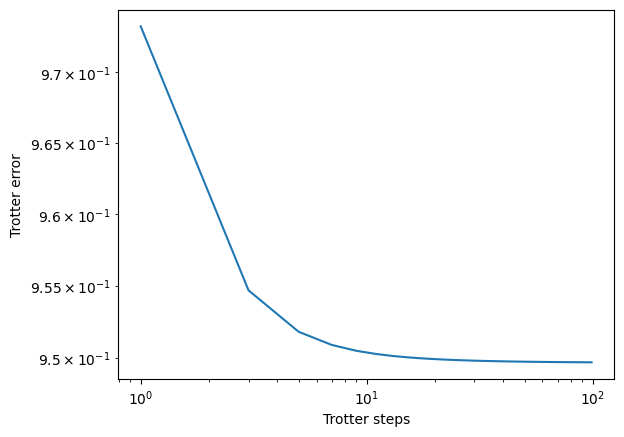

In [172]:
from qiskit.circuit.library import UnitaryGate
t_target = 0.5
U_target = UnitaryGate(U_tb(t_target))

steps=np.arange(1,101,2)  ## DO NOT EDIT

fidelities=[]
for n in tqdm(steps):
    U_trotter = U_trotterize(t_target, trotter_steps=n)
    fidelity = qi.process_fidelity(U_trotter, target=U_target)
    fidelities.append(fidelity)

plt.figure(facecolor='white')
plt.loglog(steps, 1-np.array(fidelities))
plt.ylabel('Trotter error')
plt.xlabel('Trotter steps')
plt.show()